# OUTLINE

## Step 1
#### Determine datasets to be included

Basic Price Information:

- BTC Price (USD): Bitcoin price in USD.
- ETH Price (USD): Ethereum price in USD.
- DOGE Price (USD): Dogecoin price in USD.
  
Blockchain Activity Metrics:

- Active Addresses: Number of active addresses.
- Transaction Count: Number of transactions.
- Transaction Value (USD): Total value of transactions in USD.
- Block Difficulty: Difficulty of the latest block mined.
- Total Fees (USD): Total transaction fees in USD.

Mining and Revenue Metrics:

- Revenue (USD): Revenue from mining.
- HashRate: Total computational power used in the network.
- HashPrice (USD): Cost of mining per hash.
- Miner Supply (BTC): Amount of Bitcoin held by miners.
- Miner Supply (USD): Value of Bitcoin held by miners in USD.

Market and Economic Indicators:

- SOPR: Spent Output Profit Ratio, an indicator of overall market profit and loss.
- MVRV Ratio: Market Value to Realized Value ratio.
- Rev. Puell Multiple: Revenue multiple that indicates mining revenue relative to its historical average.

- Volatility and Network Flows:
  
- Realized Volatility (24h), (30d), and (7d): Measures of volatility over different periods.
- Miner Netflows from Exchanges(BTC): Net flow of Bitcoin from/to miners to/from exchanges.
- Exchange Netflows Excl. Ex<->Ex(USD): Net flow of funds excluding exchanges.

Lagged Price Data:

- Various lag_ fields for BTC, ETH, and DOGE prices, showing past values which can be used for time-series analysis or forecasting.
- Statistical Means and Standard Deviations:
- Moving averages and standard deviations over 7 days for BTC, ETH, and DOGE prices.

Wavelet Exctracted Features:

- Denoising
- Features

## Step 2
### Data preprocessing and Feature Engineering

_____________
_____________
Data cleaning:
- Handle missing values
  - imputation
  - forward/backward filling
- Identify and remove Outlliers
- Noise reduction
_____________
Feature Engineering:
- Decompose Timestamps
- Lagged features
- Rolling Window statistics
- TA indicators
_____________
Data Transformation:
- Normalize/Standardize data
- Differencing
_____________
_____________
Sequence Creation:
- Fixed Window Sequencing: Transform the time series data into sequences that the LSTM can process.
- Overlap: You can choose to have overlapping windows (e.g., shift one time step for the next sequence) to increase the density of the training data
_____________
Train/Test Split:
- Ensure that the split between training and testing data respects the temporal order of observations
- Avoid random splits as they can introduce future leakage into the training set
_____________
Batch Size and Sequence Padding:
- Batch Size: Opt for a smaller batch size if you encounter memory issues or if you want to potentially benefit from the noise added by stochastic gradient descent during trainin
- Padding: If using batches, ensure all sequences in a batch are of the same length through padding. However, be mindful of how much padding you add as excessive padding can dilute the signal with noise
_____________
Robust Validation Strategy:
- Time Series Cross-Validation: Use techniques like forward chaining, where successive training sets are supersets of those that come before them. This mimics real-world scenarios and provides a robust estimate of the model’s performance
_____________
_____________


## Step 3
### Model Build and Evaluation

_____________
_____________
Model Architecture:
- Number of Layers: Start with one or two LSTM layers. Increasing the number of layers can help the model learn more complex patterns but can also lead to overfitting and increased computational cost.
- Number of Units: The number of units in each LSTM layer should be chosen based on the complexity of the problem. More units can capture more complex structures but may also overfit.
- Bidirectional LSTMs: Consider using bidirectional LSTMs if the context from future steps provides useful information for the model.
_____________
Regularization:
- Dropout: Use dropout in LSTM layers to prevent overfitting. Typically, dropout is applied to the inputs and/or the recurrent connections of the LSTM units.
- Recurrent Dropout: This is a specific form of dropout used in LSTM layers to drop units in the recurrent connections, which can help in regularizing the model further.
_____________
Optimizer and Learning Rate:
- Optimizer: Common choices for LSTM models include Adam or RMSprop, as they are more capable of handling the vanishing gradient problem in long sequences compared to SGD (Stochastic Gradient Descent).
- Learning Rate: Choosing the right learning rate is crucial. Use learning rate schedules or adaptive learning rate methods like learning rate decay to optimize this parameter dynamically during training.
_____________
Loss Function:
- Choose the loss function according to the nature of your prediction task:
  - For regression tasks, mean squared error (MSE) or mean absolute error (MAE) are common.
  - For classification, binary cross-entropy (for binary classification) or categorical cross-entropy (for multi-class classification) are typical choices.
_____________
Training Strategies:
- Early Stopping: Use early stopping to halt training when the model's performance on a validation set stops improving, preventing overfitting.
- Gradient Clipping: This technique limits the size of the gradients to a defined range or norm, which can prevent the exploding gradient problem in LSTMs.
_____________
Evaluation:
- Use a separate validation set to tune the parameters of your LSTM model. It’s crucial to have a test set that has not been seen during the model development phase to evaluate the model's performance.
_____________
 Iterative Refinement:
- Continuously refine the model based on feedback from real-world use or additional validation, adjusting aspects like the architecture, training duration, and input features.
_____________
_____________

## Step 4
### Implement Boosted LSTM & Best Practices

_____________
_____________
Base Model Training:
- Begin by training an initial LSTM model on the dataset.
- Compute the residuals or errors (difference between the predicted and actual values).
_____________
Sequential Training:
- Train additional LSTM models on the residuals of the previous models.
- Each model focuses on learning the patterns missed by its predecessors.
_____________
Aggregation of Predictions:
- Combine the predictions of all LSTM models, typically by weighted averaging, where weights can be determined based on the performance of each model on a validation dataset.
_____________
_____________

Model Complexity:
- Carefully choose the complexity of each LSTM in the ensemble. Too complex models might overfit, especially in later stages where the focus is on fitting residuals.
_____________
Learning Rate Adjustments:
- Adjust the learning rates for each subsequent LSTM. Later models might benefit from lower learning rates to fine-tune the predictions on residuals.
_____________
Regularization Techniques:
- Use dropout, recurrent dropout, and possibly L1/L2 regularization to prevent overfitting, especially since boosting can increase the risk of overfitting by focusing too narrowly on specific aspects of the dataset.
_____________
Early Stopping:
- Implement early stopping during training of each LSTM model to avoid overfitting on noise in the residuals.
_____________
Error Monitoring:
- Continuously monitor the error patterns; if subsequent models do not significantly improve the predictions, consider stopping the addition of new models to the ensemble.
_____________
Diverse Initialization:
- Initialize each LSTM model differently to promote model diversity, which is key to the success of ensemble methods.
_____________
_____________

# Load Data and Dependencies

In [68]:
!pip install coinmetrics-api-client
!pip install keras_tuner

#IMPORTS
import os
import pywt
import logging
import requests
import numpy as np
import pandas as pd
# import hvplot.pandas
import datetime as dt
import seaborn as sns
from os import environ
from pathlib import Path
# from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from coinmetrics.api_client import CoinMetricsClient

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint




In [53]:
#API VARIABLES

try:
    cm_api_key = environ["COIN_METRICS_API_KEY"]
    logging.info('API Key Found')
except KeyError:
    cm_api_key = ""
    logging.info('API Key Not Found')

#instantiate the client
client = CoinMetricsClient('ZNuhTAPPhlXlgdsmNvTx')

from tensorflow import keras

##### API Notes:
_______________________
- .(catalog) CATALOG OBJECTS return a list of dictionaries.

- (.get) TIMESERIES endpoints returns a list of data of a parent class type <DataCollection>

- <data = client.get_market_trades(markets="coinbase-btc-usd-spot")> will not actually retrieve the data
- you must then call a function such as <data.to_dataframe()> in order to access the data.

- outputs from the <to_dataframe()> function automatically convert the dtypes for a dataframe to the optimal pandas types.

- Parallel execution for faster data export: <parallel().to_dataframe()>, <parallel().to_list()> = it will split into many threads or processes and either store them in separate files or combine them all into one file or data structure.

- Splitting single parameter queries into many requests for increased performance: there is a feature 'time_increment' that can be used to split a single query into many based on time range, and then combine them later.

- Please note that for short time periods you can pass in a time_increment with <datetime.timedelta> to specify up to several weeks, for larger time frames you can use <dateutil.relativedelta.relativedelta> in order to split requests up by increments of months or years.
_______________________

In [54]:
# QUERY API FOR BTC METRICS

btc_metrics = ['PriceUSD',
               'AdrActCnt', 'SOPR',
               'TxCnt', 'TxTfrValUSD',
               'CapMVRVCur', 'DiffLast', 'FeeTotUSD',
               'FlowMinerIn0HopAllExNtv', 'FlowMinerOut0HopAllExNtv',
               'FlowMinerIn0HopAllNtv', 'FlowMinerOut0HopAllNtv',
               'FlowMinerIn0HopAllExUSD', 'FlowMinerOut0HopAllExUSD',
               'FlowMinerIn0HopAllUSD', 'FlowMinerOut0HopAllUSD',
               'FlowInExInclNtv', 'FlowOutExInclNtv',
               'FlowInExNtv', 'FlowOutExNtv',
               'FlowInExInclUSD', 'FlowOutExInclUSD',
               'FlowInExUSD', 'FlowOutExUSD',
               'RevUSD', 'PuellMulRev',
               'MCRC', 'MCTC', 'MOMR',
               'HashRate', 'RevHashUSD', 'RevHash1yAvgUSD',
               'SplyMiner0HopAllNtv', 'SplyMiner0HopAllUSD',
               'volume_reported_spot_usd_1d', 'volatility_realized_usd_rolling_24h',
               'volatility_realized_usd_rolling_30d', 'volatility_realized_usd_rolling_7d']
frequency = '1d'
start_time = '2014-01-01'

btc_metrics_df = client.get_asset_metrics(assets='btc',
                                          metrics=btc_metrics,
                                          start_time=start_time,
                                          frequency=frequency,
                                          end_inclusive=False,
                                          page_size=1000).parallel(
                                              time_increment=relativedelta(months=9)
                                          ).to_dataframe(optimize_pandas_types=False)

btc_metrics_df = btc_metrics_df.set_index('time')
btc_metrics_df.index = pd.to_datetime(btc_metrics_df.index.date)

eth_price = client.get_asset_metrics(assets='eth',
                                     metrics='PriceUSD',
                                     start_time=start_time,
                                     frequency=frequency,
                                     end_inclusive=False,
                                     page_size=1000).parallel(
                                         time_increment=relativedelta(months=6)
                                     ).to_dataframe(optimize_pandas_types=False)

eth_price = eth_price.set_index('time')
eth_price.index = pd.to_datetime(eth_price.index.date)

doge_price = client.get_asset_metrics(assets='doge',
                                     metrics='PriceUSD',
                                     start_time=start_time,
                                     frequency=frequency,
                                     end_inclusive=False,
                                     page_size=1000).parallel(
                                         time_increment=relativedelta(months=6)
                                     ).to_dataframe(optimize_pandas_types=False)

doge_price = doge_price.set_index('time')
doge_price.index = pd.to_datetime(doge_price.index.date)

Exporting to dataframe type: 100%|██████████| 21/21 [00:01<00:00, 13.57it/s]


# DATA CLEANING & PREPROCESSING & Visualization

In [55]:
# RENAME, REARANGE AND CONCATENATE DATAFRAMES

#Rename columns
btc_price = btc_metrics_df.rename(columns={'PriceUSD': 'btc_usd'})
doge_price = doge_price.rename(columns={'PriceUSD': 'doge_usd'})
eth_price = eth_price.rename(columns={'PriceUSD': 'eth_usd'})

btc_price = btc_price[['btc_usd']]
doge_usd = doge_price[['doge_usd']]
eth_usd = eth_price[['eth_usd']]

# Concatenate dataframes
data = pd.concat([btc_metrics_df, btc_price, doge_usd, eth_usd], axis=1)
data = data.loc['2015-08-08':]
data = data.iloc[: -1]

# Drop unrelated columns
data.drop(columns= ['PriceUSD', 'asset',
                           'FlowInExInclNtv-status', 'FlowInExInclNtv-status-time',
                           'FlowInExInclUSD-status', 'FlowInExInclUSD-status-time',
                           'FlowInExNtv-status', 'FlowInExNtv-status-time',
                           'FlowInExUSD-status', 'FlowInExUSD-status-time',
                           'FlowOutExInclNtv-status', 'FlowOutExInclNtv-status-time',
                           'FlowOutExInclUSD-status', 'FlowOutExInclUSD-status-time',
                           'FlowOutExNtv-status', 'FlowOutExNtv-status-time'], inplace = True)

# Reorder and rename columns
reorder = ['btc_usd', 'eth_usd', 'doge_usd', 'AdrActCnt', 'SOPR',
           'TxCnt', 'TxTfrValUSD', 'CapMVRVCur',
           'DiffLast', 'FeeTotUSD',
           'FlowMinerIn0HopAllExNtv', 'FlowMinerOut0HopAllExNtv',
           'FlowMinerIn0HopAllNtv', 'FlowMinerOut0HopAllNtv',
           'FlowMinerIn0HopAllExUSD', 'FlowMinerOut0HopAllExUSD',
           'FlowMinerIn0HopAllUSD', 'FlowMinerOut0HopAllUSD',
           'FlowInExInclNtv', 'FlowOutExInclNtv',
           'FlowInExNtv', 'FlowOutExNtv',
           'FlowInExInclUSD', 'FlowOutExInclUSD',
           'FlowInExUSD', 'FlowOutExUSD',
           'RevUSD', 'PuellMulRev',
           'MCRC', 'MCTC', 'MOMR',
           'HashRate', 'RevHashUSD', 'RevHash1yAvgUSD',
           'SplyMiner0HopAllNtv', 'SplyMiner0HopAllUSD',
           'volume_reported_spot_usd_1d', 'volatility_realized_usd_rolling_24h',
           'volatility_realized_usd_rolling_30d', 'volatility_realized_usd_rolling_7d']

data = pd.DataFrame(data[reorder])

rename = {'btc_usd': 'BTC Price (USD)', 'eth_usd': 'ETH Price (USD)', 'doge_usd': 'DOGE Price (USD)',
          'AdrActCnt': 'Active Addresses', 'SOPR': 'SOPR',
          'TxCnt': 'Transaction Count', 'TxTfrValUSD': 'Transaction Value (USD)',
          'CapMVRVCur': 'MVRV Ratio', 'DiffLast': 'Block Difficulty',
          'FeeTotUSD': 'Total Fees (USD)', 'RevUSD': 'Revenue (USD)', 'PuellMulRev': 'Rev. Puell Multiple',
          'MCRC': 'MaCap to Realizedcap Ratio(USD)', 'MCTC': 'MCap/Thermocap Ratio(USD)',
          'MOMR': 'Miner Outflow to Revenue Ratio','RevHashUSD': 'HashPrice (USD)', 'RevHash1yAvgUSD': 'HashPrice 1yr/avg (USD)',
          'SplyMiner0HopAllNtv': 'Miner Supply (BTC)', 'SplyMiner0HopAllUSD': 'Miner Supply (USD)',
          'volume_reported_spot_usd_1d': 'Volume (USD)', 'volatility_realized_usd_rolling_24h': 'Realized Volatility (24h)',
          'volatility_realized_usd_rolling_30d': 'Realized Volatility (30d)', 'volatility_realized_usd_rolling_7d': 'Realized Volatility (7d)',}

data = data.rename(columns=rename)

#check for missing values
missing_values = False
for column in data.columns:
    # Count the number of missing values in each column
    missing_values = data[column].isnull().sum()
    if missing_values > 0:
        print(f"Column '{column}' has {missing_values} missing value(s).")
        missing_values_found = True

        if not missing_values_found:
            print("No missing values found in any column.")

# Set Index and and data types
data.index.name = 'date'
data = data.astype(float)
pd.set_option('display.max_columns', None)

# Display dataframe
display(data.head(), data.tail())

,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),FlowMinerIn0HopAllExNtv,FlowMinerOut0HopAllExNtv,FlowMinerIn0HopAllNtv,FlowMinerOut0HopAllNtv,FlowMinerIn0HopAllExUSD,FlowMinerOut0HopAllExUSD,FlowMinerIn0HopAllUSD,FlowMinerOut0HopAllUSD,FlowInExInclNtv,FlowOutExInclNtv,FlowInExNtv,FlowOutExNtv,FlowInExInclUSD,FlowOutExInclUSD,FlowInExUSD,FlowOutExUSD,Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-08,261.450276,1.19999,0.000158,266587.0,0.995648,100950.0,2.734332e+08,0.911661,5.269984e+10,5806.842316,71.642948,291.467959,4408.793090,15788.990621,18731.068453,76204.378280,1.152680e+06,4.128036e+06,87744.058905,92736.221560,80696.918441,85689.081097,2.294071e+07,2.424591e+07,2.109823e+07,2.240343e+07,1.058144e+06,0.902738,0.322084,1.001739,6.235399,420413.404986,0.000029,4.205853,1.938520e+06,5.068267e+08,1.887439e+07,0.286687,0.497451,0.286394
2015-08-09,266.342020,1.19999,0.000165,262571.0,0.943904,88144.0,3.096611e+08,0.933177,5.269984e+10,4952.554125,6.080475,158.852931,3819.741903,2457.884207,1619.485880,42309.210663,1.017358e+06,6.546378e+05,39538.860660,37446.809403,35197.976089,33105.924832,1.053086e+07,9.973659e+06,9.374700e+06,8.817499e+06,9.504667e+05,0.814177,0.329246,1.018646,39.349228,372000.719336,0.000030,4.171636,1.939885e+06,5.166730e+08,1.227010e+07,0.588255,0.499559,0.340035
2015-08-10,264.928825,1.19999,0.000163,292834.0,0.995600,115928.0,2.794150e+08,0.928561,5.269984e+10,7563.840456,66.662538,2107.088625,4424.720225,4151.060759,17660.827941,558228.514019,1.172236e+06,1.099736e+06,57637.564913,55598.779261,54376.744631,52337.958979,1.526985e+07,1.472972e+07,1.440597e+07,1.386583e+07,1.113642e+06,0.957324,0.327539,1.012449,5.946437,437493.803726,0.000029,4.137356,1.940159e+06,5.140041e+08,1.036210e+07,0.426015,0.448157,0.351534
2015-08-11,271.421736,0.99000,0.000165,271613.0,1.000741,115981.0,2.880825e+08,0.951276,5.269984e+10,7128.842169,2.457470,162.347954,4207.026167,4204.814970,667.010730,44064.763632,1.141878e+06,1.141278e+06,63185.829578,75307.144018,56005.535757,68126.850196,1.715001e+07,2.044000e+07,1.520112e+07,1.849111e+07,1.106387e+06,0.954481,0.335434,1.036330,7.415329,424395.186848,0.000030,4.104347,1.940164e+06,5.266027e+08,1.142253e+07,0.273624,0.423970,0.344866
2015-08-12,268.143868,1.28800,0.000161,278802.0,0.997848,116970.0,3.281444e+08,0.939981,5.269984e+10,6800.579287,12.470272,224.572039,3319.458778,3623.210536,3343.827069,60217.615274,8.900925e+05,9.715417e+05,71013.881815,72890.801884,65315.932436,67192.852504,1.904194e+07,1.954522e+07,1.751407e+07,1.801735e+07,8.514538e+05,0.737387,0.331423,1.023298,10.576617,330085.145327,0.000030,4.071609,1.939861e+06,5.201618e+08,1.334718e+07,0.265499,0.404798,0.346838


,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),FlowMinerIn0HopAllExNtv,FlowMinerOut0HopAllExNtv,FlowMinerIn0HopAllNtv,FlowMinerOut0HopAllNtv,FlowMinerIn0HopAllExUSD,FlowMinerOut0HopAllExUSD,FlowMinerIn0HopAllUSD,FlowMinerOut0HopAllUSD,FlowInExInclNtv,FlowOutExInclNtv,FlowInExNtv,FlowOutExNtv,FlowInExInclUSD,FlowOutExInclUSD,FlowInExUSD,FlowOutExUSD,Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-17,61324.218429,2984.858113,0.147673,794595.0,0.996383,385424.0,1.756049e+10,2.150116,8.638856e+13,7.472410e+06,0.0,13.945500,998.805385,900.907608,0.0,8.551969e+05,6.125096e+07,5.524745e+07,23640.658208,24682.841121,19332.440024,20374.622936,1.449745e+09,1.513656e+09,1.185547e+09,1.249458e+09,5.998127e+07,1.569551,0.472892,4.157119,47.067763,5.883326e+08,1.179992e-06,0.081007,1.791542e+06,1.098649e+11,2.086683e+10,0.729842,0.659146,0.818223
2024-04-18,63510.145003,3067.805941,0.152146,823945.0,1.012475,416810.0,2.484950e+10,2.223657,8.638856e+13,6.806387e+06,0.0,13.612105,1035.155871,874.705754,0.0,8.645068e+05,6.574290e+07,5.555269e+07,39467.458446,28259.708256,33737.092871,22529.342682,2.506584e+09,1.794778e+09,2.142648e+09,1.430842e+09,6.436246e+07,1.679531,0.488527,4.296420,60.018488,6.226878e+08,1.196323e-06,0.081078,1.791703e+06,1.137913e+11,1.657296e+10,0.702421,0.659613,0.824296
2024-04-19,63762.631030,3055.969496,0.154800,880733.0,1.014609,398632.0,1.894217e+10,2.229522,8.638856e+13,1.146940e+07,0.0,13.745373,1132.238448,971.706056,0.0,8.764412e+05,7.219450e+07,6.195853e+07,21821.216888,23298.751592,19383.783906,20861.318610,1.391378e+09,1.485590e+09,1.235961e+09,1.330173e+09,7.084835e+07,1.842620,0.489628,4.307285,33.994693,6.484542e+08,1.264552e-06,0.081170,1.791863e+06,1.142539e+11,2.403726e+10,0.651559,0.641132,0.838189
2024-04-20,64907.992837,3155.528942,0.162685,509709.0,1.006168,630654.0,6.304627e+09,2.268874,8.638856e+13,7.830932e+07,0.0,14.246484,1633.929345,683.428481,0.0,9.247107e+05,1.060551e+08,4.435997e+07,6987.875979,8904.822129,5338.230462,7255.176612,4.535690e+08,5.779941e+08,3.464938e+08,4.709190e+08,1.046782e+08,2.707167,0.498473,4.379366,5.511725,5.582718e+08,2.170185e-06,0.081486,1.792814e+06,1.163680e+11,1.015498e+10,1.042860,0.640876,0.891373
2024-04-21,64968.192620,3147.659615,0.158233,565959.0,1.005946,644793.0,7.118152e+09,2.270179,8.638856e+13,2.179872e+07,0.0,27.705909,809.520011,1996.389810,0.0,1.800003e+06,5.259305e+07,1.297018e+08,10255.159095,9492.417755,7994.936381,7232.195041,6.662592e+08,6.167052e+08,5.194166e+08,4.698626e+08,5.022231e+07,1.296648,0.498658,4.379202,20.228773,6.012158e+08,9.668350e-07,0.081515,1.791627e+06,1.163988e+11,9.311977e+09,0.456264,0.633725,0.765155


# FEATURE ENGINEEERING

In [56]:
# MINER AND EXCHANGE NETFLOW FEATURES

#calculate miner and exchange netflows
data['Miner Netflows from Exchanges(BTC)'] = data['FlowMinerIn0HopAllExNtv'] - data['FlowMinerOut0HopAllExNtv']
data['Miner Netflows from Exchanges(USD)'] = data['FlowMinerIn0HopAllExUSD'] - data['FlowMinerOut0HopAllExUSD']
data['Miner Netflows All(BTC)'] = data['FlowMinerIn0HopAllNtv'] - data['FlowMinerOut0HopAllNtv']
data['Miner Netflows All(USD)'] = data['FlowMinerIn0HopAllUSD'] - data['FlowMinerOut0HopAllUSD']
data['Exchange Netflows Excl. Ex<->Ex(BTC)'] = data['FlowInExNtv'] - data['FlowOutExNtv']
data['Exchange Netflows Excl. Ex<->Ex(USD)'] = data['FlowInExUSD'] - data['FlowOutExUSD']
data['Exchange Netflows All(BTC)'] = data['FlowInExInclNtv'] - data['FlowOutExInclNtv']
data['Exchange Netflows All(USD)'] = data['FlowInExInclUSD'] - data['FlowOutExInclUSD']

#drop original columns
data.drop(columns = ['FlowMinerIn0HopAllExNtv', 'FlowMinerOut0HopAllExNtv',
                     'FlowMinerIn0HopAllNtv', 'FlowMinerOut0HopAllNtv',
                     'FlowMinerIn0HopAllExUSD', 'FlowMinerOut0HopAllExUSD',
                     'FlowMinerIn0HopAllUSD', 'FlowMinerOut0HopAllUSD',
                     'FlowInExInclNtv', 'FlowOutExInclNtv',
                     'FlowInExNtv', 'FlowOutExNtv',
                     'FlowInExInclUSD', 'FlowOutExInclUSD',
                     'FlowInExUSD', 'FlowOutExUSD'], inplace = True)

#Display dataframe
display(data.head(), data.tail())

,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-08,261.450276,1.19999,0.000158,266587.0,0.995648,100950.0,2.734332e+08,0.911661,5.269984e+10,5806.842316,1.058144e+06,0.902738,0.322084,1.001739,6.235399,420413.404986,0.000029,4.205853,1.938520e+06,5.068267e+08,1.887439e+07,0.286687,0.497451,0.286394,-219.825011,-57473.309828,-11380.197532,-2.975356e+06,-4992.162656,-1.305202e+06,-4992.162656,-1.305202e+06
2015-08-09,266.342020,1.19999,0.000165,262571.0,0.943904,88144.0,3.096611e+08,0.933177,5.269984e+10,4952.554125,9.504667e+05,0.814177,0.329246,1.018646,39.349228,372000.719336,0.000030,4.171636,1.939885e+06,5.166730e+08,1.227010e+07,0.588255,0.499559,0.340035,-152.772457,-40689.724783,1361.857696,3.627199e+05,2092.051257,5.572012e+05,2092.051257,5.572012e+05
2015-08-10,264.928825,1.19999,0.000163,292834.0,0.995600,115928.0,2.794150e+08,0.928561,5.269984e+10,7563.840456,1.113642e+06,0.957324,0.327539,1.012449,5.946437,437493.803726,0.000029,4.137356,1.940159e+06,5.140041e+08,1.036210e+07,0.426015,0.448157,0.351534,-2040.426086,-540567.686077,273.659466,7.250028e+04,2038.785652,5.401331e+05,2038.785652,5.401331e+05
2015-08-11,271.421736,0.99000,0.000165,271613.0,1.000741,115981.0,2.880825e+08,0.951276,5.269984e+10,7128.842169,1.106387e+06,0.954481,0.335434,1.036330,7.415329,424395.186848,0.000030,4.104347,1.940164e+06,5.266027e+08,1.142253e+07,0.273624,0.423970,0.344866,-159.890485,-43397.752902,2.211197,6.001668e+02,-12121.314440,-3.289988e+06,-12121.314440,-3.289988e+06
2015-08-12,268.143868,1.28800,0.000161,278802.0,0.997848,116970.0,3.281444e+08,0.939981,5.269984e+10,6800.579287,8.514538e+05,0.737387,0.331423,1.023298,10.576617,330085.145327,0.000030,4.071609,1.939861e+06,5.201618e+08,1.334718e+07,0.265499,0.404798,0.346838,-212.101767,-56873.788205,-303.751758,-8.144917e+04,-1876.920069,-5.032846e+05,-1876.920069,-5.032846e+05


,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-17,61324.218429,2984.858113,0.147673,794595.0,0.996383,385424.0,1.756049e+10,2.150116,8.638856e+13,7.472410e+06,5.998127e+07,1.569551,0.472892,4.157119,47.067763,5.883326e+08,1.179992e-06,0.081007,1.791542e+06,1.098649e+11,2.086683e+10,0.729842,0.659146,0.818223,-13.945500,-8.551969e+05,97.897778,6.003505e+06,-1042.182913,-6.391105e+07,-1042.182913,-6.391105e+07
2024-04-18,63510.145003,3067.805941,0.152146,823945.0,1.012475,416810.0,2.484950e+10,2.223657,8.638856e+13,6.806387e+06,6.436246e+07,1.679531,0.488527,4.296420,60.018488,6.226878e+08,1.196323e-06,0.081078,1.791703e+06,1.137913e+11,1.657296e+10,0.702421,0.659613,0.824296,-13.612105,-8.645068e+05,160.450117,1.019021e+07,11207.750189,7.118058e+08,11207.750189,7.118058e+08
2024-04-19,63762.631030,3055.969496,0.154800,880733.0,1.014609,398632.0,1.894217e+10,2.229522,8.638856e+13,1.146940e+07,7.084835e+07,1.842620,0.489628,4.307285,33.994693,6.484542e+08,1.264552e-06,0.081170,1.791863e+06,1.142539e+11,2.403726e+10,0.651559,0.641132,0.838189,-13.745373,-8.764412e+05,160.532392,1.023597e+07,-1477.534704,-9.421150e+07,-1477.534704,-9.421150e+07
2024-04-20,64907.992837,3155.528942,0.162685,509709.0,1.006168,630654.0,6.304627e+09,2.268874,8.638856e+13,7.830932e+07,1.046782e+08,2.707167,0.498473,4.379366,5.511725,5.582718e+08,2.170185e-06,0.081486,1.792814e+06,1.163680e+11,1.015498e+10,1.042860,0.640876,0.891373,-14.246484,-9.247107e+05,950.500864,6.169510e+07,-1916.946150,-1.244251e+08,-1916.946150,-1.244251e+08
2024-04-21,64968.192620,3147.659615,0.158233,565959.0,1.005946,644793.0,7.118152e+09,2.270179,8.638856e+13,2.179872e+07,5.022231e+07,1.296648,0.498658,4.379202,20.228773,6.012158e+08,9.668350e-07,0.081515,1.791627e+06,1.163988e+11,9.311977e+09,0.456264,0.633725,0.765155,-27.705909,-1.800003e+06,-1186.869799,-7.710879e+07,762.741340,4.955393e+07,762.741340,4.955393e+07


In [57]:
# LAGGED AND ROLLING WINDOW FEATURES

# Define a function to create lagged and rolling window features
def create_lagged_rolling_features(data, column_names, lag_days=5, roll_window=7):
    """
    Create lagged and rolling window features for given column names.
    Parameters:
    - data: Pandas DataFrame with timeseries data.
    - column_names: List of column names to create features for.
    - lag_days: Number of days to create lagged features for. Default is 5 days.
    - roll_window: Window size for calculating rolling features. Default is 7 days.
    Returns:
    - DataFrame with the original data and the new features.
    """
    for column in column_names:
        # Create lagged features
        for lag in range(1, lag_days + 1):
            data[f'{column}_lag_{lag}'] = data[column].shift(lag)

        # Create rolling mean and std features
        data[f'{column}_{roll_window}d_mean'] = data[column].rolling(window=roll_window).mean()
        data[f'{column}_{roll_window}d_std'] = data[column].rolling(window=roll_window).std()

    # Drop initial rows with NaN values due to lagging and rolling
    data.dropna(inplace=True)
    return data

# Define column names
column_names = ['BTC Price (USD)',
                'ETH Price (USD)',
                'DOGE Price (USD)',
                'Volume (USD)'
                ]

#Call the function to create lagged and rolling features
data_ = create_lagged_rolling_features(data, column_names)

#export to csv
data.to_csv('data.csv', index=True)

#display updated dataframe
display(data.head(), data.tail())

,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD),BTC Price (USD)_lag_1,BTC Price (USD)_lag_2,BTC Price (USD)_lag_3,BTC Price (USD)_lag_4,BTC Price (USD)_lag_5,BTC Price (USD)_7d_mean,BTC Price (USD)_7d_std,ETH Price (USD)_lag_1,ETH Price (USD)_lag_2,ETH Price (USD)_lag_3,ETH Price (USD)_lag_4,ETH Price (USD)_lag_5,ETH Price (USD)_7d_mean,ETH Price (USD)_7d_std,DOGE Price (USD)_lag_1,DOGE Price (USD)_lag_2,DOGE Price (USD)_lag_3,DOGE Price (USD)_lag_4,DOGE Price (USD)_lag_5,DOGE Price (USD)_7d_mean,DOGE Price (USD)_7d_std,Volume (USD)_lag_1,Volume (USD)_lag_2,Volume (USD)_lag_3,Volume (USD)_lag_4,Volume (USD)_lag_5,Volume (USD)_7d_mean,Volume (USD)_7d_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-14,266.355942,1.795044,0.000158,268926.0,0.996663,110518.0,3.207094e+08,0.934356,5.269984e+10,6441.490573,952005.083092,0.829077,0.329237,1.014894,10.886097,372000.719336,0.000030,4.011787,1.943184e+06,5.175786e+08,1.406769e+07,0.227018,0.342769,0.364884,-212.068734,-56485.767280,1165.429705,310419.126394,32190.934354,8.574247e+06,32190.934354,8.574247e+06,264.691628,268.143868,271.421736,264.928825,266.342020,266.190614,3.096772,1.884800,1.288000,0.990000,1.199990,1.19999,1.365402,0.337483,0.000157,0.000161,0.000165,0.000163,0.000165,0.000161,0.000003,1.398782e+07,1.334718e+07,1.142253e+07,1.036210e+07,1.227010e+07,1.347597e+07,2.742827e+06
2015-08-15,261.936837,1.782222,0.000153,272413.0,0.992420,96407.0,2.527552e+08,0.919340,5.269984e+10,5452.656833,902586.322340,0.788235,0.323994,0.997767,5.668088,358902.102458,0.000029,3.983631,1.943904e+06,5.091800e+08,9.850568e+06,0.252693,0.338853,0.361277,-332.837305,-87182.350855,716.829919,187764.161490,-26342.955366,-6.900190e+06,-26342.955366,-6.900190e+06,266.355942,264.691628,268.143868,271.421736,264.928825,266.260122,2.975734,1.795044,1.884800,1.288000,0.990000,1.19999,1.448578,0.360860,0.000158,0.000157,0.000161,0.000165,0.000163,0.000160,0.000005,1.406769e+07,1.398782e+07,1.334718e+07,1.142253e+07,1.036210e+07,1.218686e+07,1.708139e+06
2015-08-16,258.930817,1.533074,0.000149,275996.0,0.989009,88617.0,2.593369e+08,0.909505,5.269984e+10,4856.927836,898168.247831,0.786577,0.320885,0.986991,4.656636,361521.825834,0.000029,3.953887,1.945335e+06,5.037072e+08,1.629994e+07,0.245711,0.318061,0.299518,-154.878213,-40102.742214,1430.214088,370326.502742,2678.735983,6.936073e+05,2678.735983,6.936073e+05,261.936837,266.355942,264.691628,268.143868,271.421736,265.201379,4.061925,1.782222,1.795044,1.884800,1.288000,0.99000,1.496161,0.344193,0.000153,0.000158,0.000157,0.000161,0.000165,0.000158,0.000006,9.850568e+06,1.406769e+07,1.398782e+07,1.334718e+07,1.142253e+07,1.276255e+07,2.312900e+06
2015-08-17,258.009398,1.296380,0.000150,293079.0,0.995797,120631.0,3.817098e+08,0.906685,5.269984e+10,6407.858212,954592.396983,0.838363,0.320150,0.983827,10.108647,385099.336214,0.000029,3.925611,1.946542e+06,5.022263e+08,1.115458e+07,0.487183,0.320391,0.312555,-250.244834,-64565.519044,1181.211172,304763.583700,2623.045326,6.767703e+05,2623.045326,6.767703e+05,258.930817,261.936837,266.355942,264.691628,268.143868,264.212890,4.895677,1.533074,1.782222,1.795044,1.884800,1.28800,1.509931,0.332084,0.000149,0.000153,0.000158,0.000157,0.000161,0.000156,0.000006,1.629994e+07,9.850568e+06,1.406769e+07,1.398782e+07,1.334718e+07,1.287576e+07,2.

,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD),BTC Price (USD)_lag_1,BTC Price (USD)_lag_2,BTC Price (USD)_lag_3,BTC Price (USD)_lag_4,BTC Price (USD)_lag_5,BTC Price (USD)_7d_mean,BTC Price (USD)_7d_std,ETH Price (USD)_lag_1,ETH Price (USD)_lag_2,ETH Price (USD)_lag_3,ETH Price (USD)_lag_4,ETH Price (USD)_lag_5,ETH Price (USD)_7d_mean,ETH Price (USD)_7d_std,DOGE Price (USD)_lag_1,DOGE Price (USD)_lag_2,DOGE Price (USD)_lag_3,DOGE Price (USD)_lag_4,DOGE Price (USD)_lag_5,DOGE Price (USD)_7d_mean,DOGE Price (USD)_7d_std,Volume (USD)_lag_1,Volume (USD)_lag_2,Volume (USD)_lag_3,Volume (USD)_lag_4,Volume (USD)_lag_5,Volume (USD)_7d_mean,Volume (USD)_7d_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-17,61324.218429,2984.858113,0.147673,794595.0,0.996383,385424.0,1.756049e+10,2.150116,8.638856e+13,7.472410e+06,5.998127e+07,1.569551,0.472892,4.157119,47.067763,5.883326e+08,1.179992e-06,0.081007,1.791542e+06,1.098649e+11,2.086683e+10,0.729842,0.659146,0.818223,-13.945500,-8.551969e+05,97.897778,6.003505e+06,-1042.182913,-6.391105e+07,-1042.182913,-6.391105e+07,63784.820334,63393.325166,65648.809960,64551.648288,67098.113692,65121.069925,2827.206758,3088.467372,3103.088036,3158.850379,3030.380064,3234.931643,3157.811391,173.119464,0.156437,0.161590,0.162886,0.153801,0.174294,0.164365,0.015450,1.971685e+10,1.989880e+10,2.254849e+10,2.637653e+10,2.169774e+10,2.075844e+10,3.661694e+09
2024-04-18,63510.145003,3067.805941,0.152146,823945.0,1.012475,416810.0,2.484950e+10,2.223657,8.638856e+13,6.806387e+06,6.436246e+07,1.679531,0.488527,4.296420,60.018488,6.226878e+08,1.196323e-06,0.081078,1.791703e+06,1.137913e+11,1.657296e+10,0.702421,0.659613,0.824296,-13.612105,-8.645068e+05,160.450117,1.019021e+07,11207.750189,7.118058e+08,11207.750189,7.118058e+08,61324.218429,63784.820334,63393.325166,65648.809960,64551.648288,64187.297267,1834.382652,2984.858113,3088.467372,3103.088036,3158.850379,3030.380064,3095.483078,82.472906,0.147673,0.156437,0.161590,0.162886,0.153801,0.158404,0.008776,2.086683e+10,1.971685e+10,1.989880e+10,2.254849e+10,2.637653e+10,2.109689e+10,3.005593e+09
2024-04-19,63762.631030,3055.969496,0.154800,880733.0,1.014609,398632.0,1.894217e+10,2.229522,8.638856e+13,1.146940e+07,7.084835e+07,1.842620,0.489628,4.307285,33.994693,6.484542e+08,1.264552e-06,0.081170,1.791863e+06,1.142539e+11,2.403726e+10,0.651559,0.641132,0.838189,-13.745373,-8.764412e+05,160.532392,1.023597e+07,-1477.534704,-9.421150e+07,-1477.534704,-9.421150e+07,63510.145003,61324.218429,63784.820334,63393.325166,65648.809960,63710.799744,1310.718519,3067.805941,2984.858113,3088.467372,3103.088036,3158.850379,3069.917057,55.303334,0.152146,0.147673,0.156437,0.161590,0.162886,0.155619,0.005296,1.657296e+10,2.086683e+10,1.971685e+10,1.989880e+10,2.254849e+10,2.143110e+10,3.206877e+09
2024-04-20,64907.992837,3155.528942,0.162685,509709.0,1.006168,630654.0,6.304627e+09,2.268874,8.638856e+13,7.830932e+07,1.046782e+08,2.707167,0.498473,4.379366,5.511725,5.582718e+08,2.170185e-06,0.081486,1.792814e+06,1.163680e+11,1.015498e+10,1.042860,0.640876,0.891373,-14.246484,-9.247107e+05,950.500864,6.169510e+07,-1916.946150,-1.244251e+08,-1916.946150,-1.244251e+08,63762.631030,63510.145003,61324.218429,63784.820334,63393.325166,63761.706108,1354.990961,3055.969496,3067.805941,2984.858113,3088.467372,3103.08

In [58]:
#VISUALIZE THE DATA

# Define a function to visualize and export line plots, boxplots, and histograms
def visualize_and_export_columns(data, column_names, plot_dir='plots'):
    """
    Generate line plots, boxplots, and histograms for the given column names
    and export the plots as images.
    Parameters:
    - data: Pandas DataFrame with the data.
    - column_names: List of column names to be visualized.
    - plot_dir: Directory where plots will be saved.
    """
    for column in column_names:
        # Create a figure for the plots
        fig = plt.figure(figsize=(14, 10))

        # Add a subplot for the line plot
        ax0 = fig.add_subplot(3, 1, 1)
        sns.lineplot(data=data, x=data.index, y=column, ax=ax0)
        ax0.set_title(f'{column} Over Time', fontsize=14)
        ax0.set_xlabel('Date', fontsize=12)
        ax0.set_ylabel(column, fontsize=12)
        ax0.grid(True)

        # Add a subplot for the boxplot
        ax1 = fig.add_subplot(3, 1, 2)
        sns.boxplot(data=data, x=column, ax=ax1)
        ax1.set_title(f'Boxplot of {column}', fontsize=14)
        ax1.set_xlabel(column, fontsize=12)
        ax1.set_ylabel('Values', fontsize=12)

        # Add a subplot for the histogram
        ax2 = fig.add_subplot(3, 1, 3)
        sns.histplot(data=data, x=column, kde=True, ax=ax2)
        ax2.set_title(f'Histogram of {column}', fontsize=14)
        ax2.set_xlabel(column, fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        plt.tight_layout()

        # Show plots
        # plt.show()

        # Save the plot
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

        valid_filename = column.replace('/', '_')  # Replace slash with underscore
        plot_filename = f"{plot_dir}/{valid_filename}_boxplot_histogram.png"
        plt.savefig(plot_filename)
        plt.close()  # Close the figure to free memory

#Define column names to visualize
column_names = ['BTC Price (USD)',
                'Active Addresses',
                'SOPR',
                'Transaction Count',
                'Transaction Value (USD)',
                'MVRV Ratio',
                'Block Difficulty',
                'Total Fees (USD)',
                'Revenue (USD)',
                'Rev. Puell Multiple',
                'MaCap to Realizedcap Ratio(USD)',
                'MCap/Thermocap Ratio(USD)',
                'Miner Outflow to Revenue Ratio',
                'HashRate',
                'HashPrice (USD)',
                'HashPrice 1yr/avg (USD)',
                'Miner Supply (BTC)',
                'Miner Supply (USD)',
                'Volume (USD)',
                'Realized Volatility (24h)',
                'Realized Volatility (30d)',
                'Realized Volatility (7d)',
                'Miner Netflows from Exchanges(BTC)',
                'Miner Netflows from Exchanges(USD)',
                'Miner Netflows All(BTC)',
                'Miner Netflows All(USD)',
                'Exchange Netflows Excl. Ex<->Ex(BTC)',
                'Exchange Netflows Excl. Ex<->Ex(USD)',
                'Exchange Netflows All(BTC)',
                'Exchange Netflows All(USD)'
]

# Call the function to visualize and export the plots
visualize_and_export_columns(data, column_names)


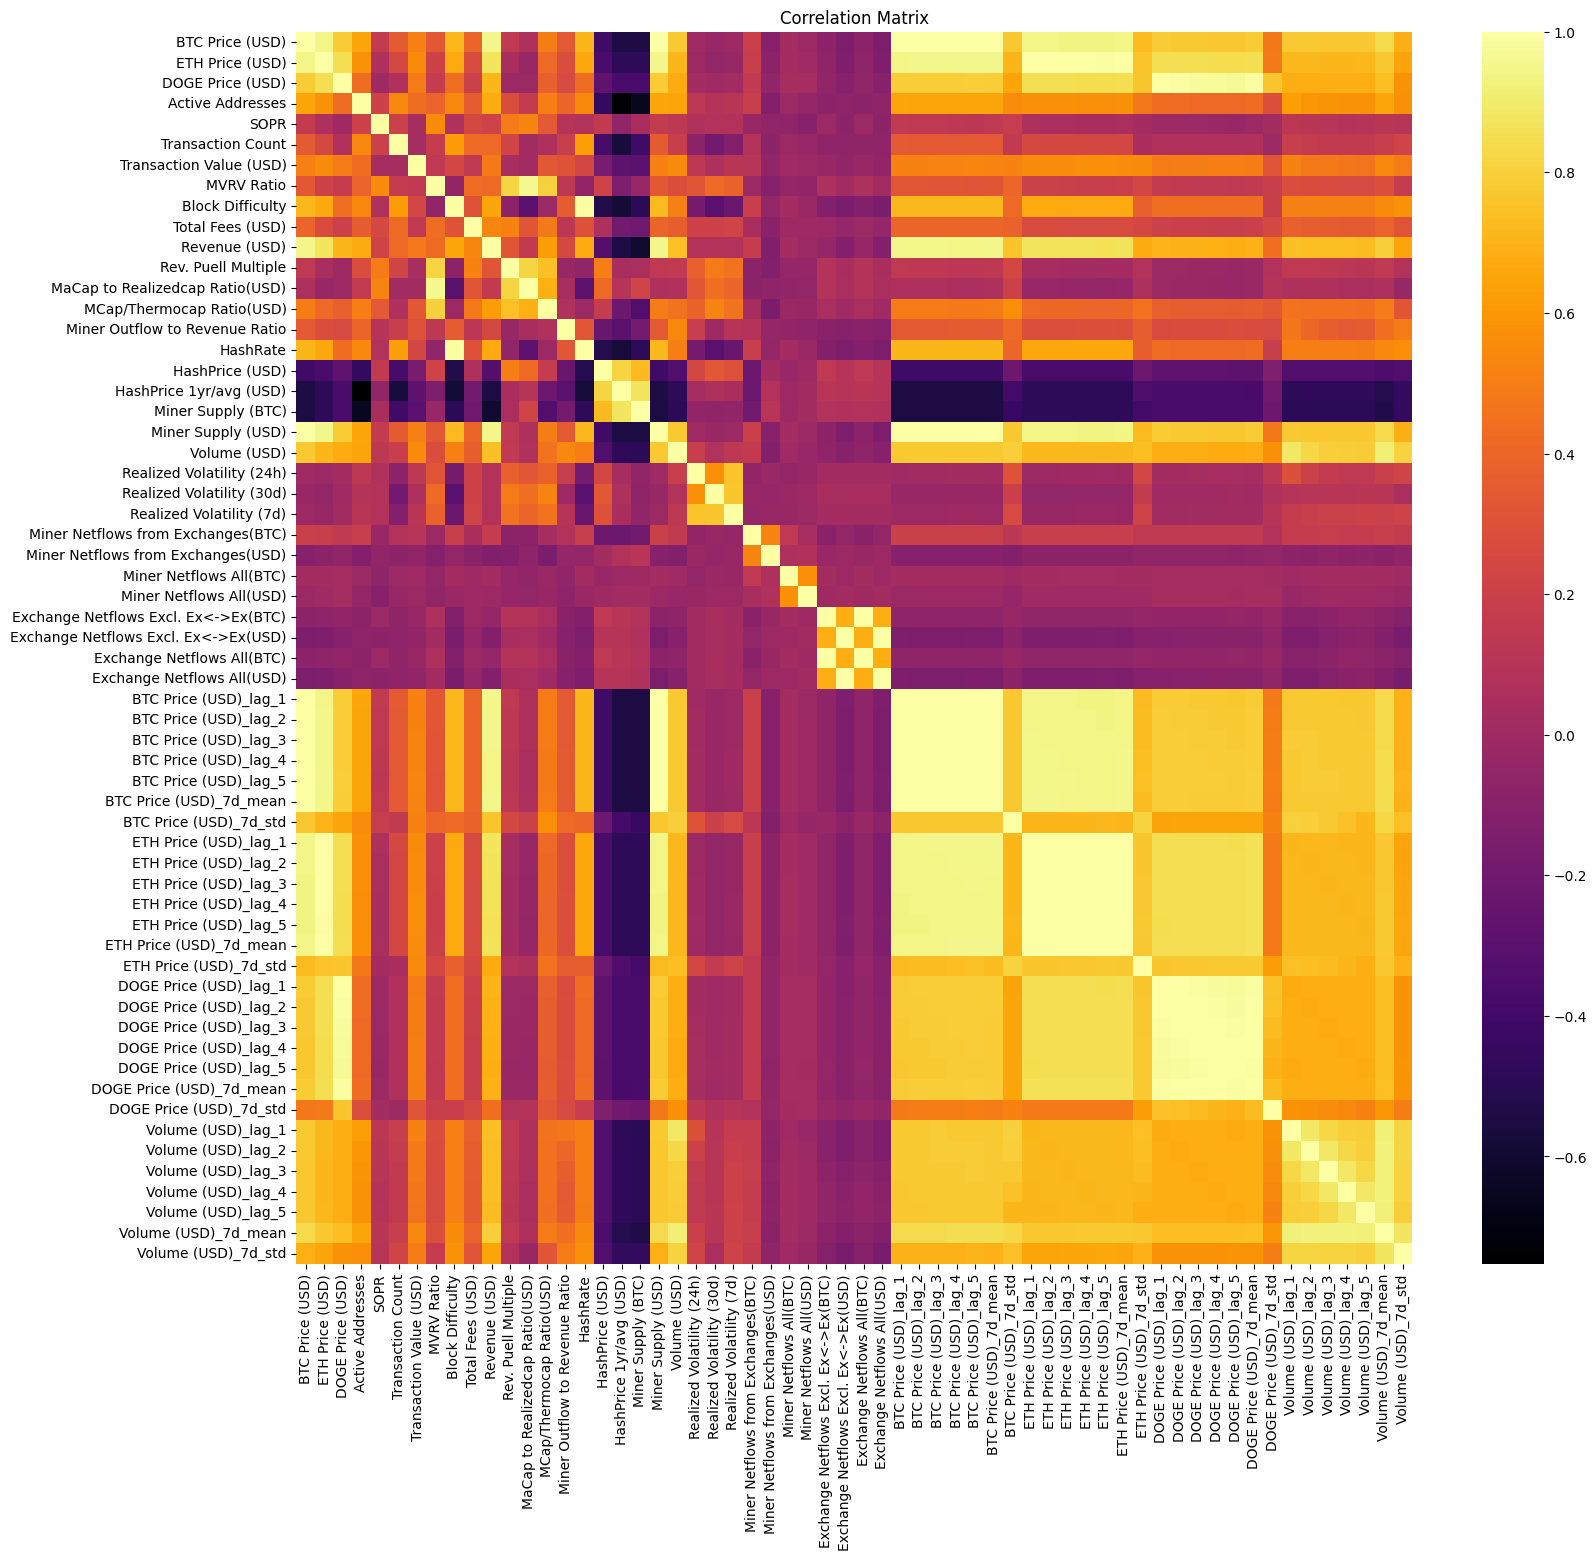

<Figure size 640x480 with 0 Axes>

In [59]:
# CALCULATE AND PLOT COORELATION MATRIX

# Calculate the correlation matrix
correlation_matrix = data.corr(method='pearson')

#plot heatmap of correlation matrix
plt.figure(figsize=(18, 16))  # Adjust the size as needed
sns.heatmap(correlation_matrix, fmt=".2f", cmap='inferno')
plt.title('Correlation Matrix')
plt.show()

#export plot to csv
plot_dir = 'plots'

if not os.path.exists(plot_dir):
  os.makedirs(plot_dir)

file_name = f"{plot_dir}/correlation_matrix.png"
plt.savefig(file_name)


#### Wavelet Transform Notes:

- **Wavelet transforms** are mathematical functions that decompose data into different frequency components and then analyze each component with a resolution matched to its scale.

##### Strengths:
__________________________
- **Non-Stationarity:** Financial data, such as Bitcoin prices, often exhibit non-stationary behavior where statistical properties change over time. Wavelets handle such data effectively because they adapt to changes in local characteristics of the signal.

- **Feature Detection**: They can detect and isolate various features such as trends, breakdown points, and discontinuities at different scales.
- **Noise Reduction**: Wavelet transforms can smooth out noise without greatly distorting the signal, providing a clearer analysis of the underlying trends.
- **Anomaly Detection**: They can highlight anomalies or unusual changes in time series data, which is crucial for fraud detection in finance or identifying market shocks.
__________________________
- **Continuous Wavelet Transform (CWT):** Offers a complete and highly detailed decomposition of the signal, used primarily for scientific and engineering applications where precision is crucial.

- **Discrete Wavelet Transform (DWT)**: Provides a sampled version of the CWT and is more computationally efficient, making it suitable for real-time and digital signal processing applications.
__________________________
- **Choosing the Right Wavelet:** Selecting an appropriate wavelet type based on the data characteristics. Common choices in financial applications include Daubechies, Coiflets, or Morlet wavelets.

- **Decomposition Levels:** Determining how many levels of decomposition are necessary to capture the essential information without overfitting or underfitting.
- **Feature Construction:** Transforming the wavelet coefficients into features that can be used for training the model. This might involve aggregating or summarizing the coefficients in various ways.
  __________________________
- **Denoising**: If the purpose is to denoise the signal, you would typically apply a threshold to the detail coefficients before reconstruction to remove noise.
  
- **Feature Extraction:** For time-series analysis or machine learning, you can extract features from the wavelet coefficients. These could be statistical features (mean, variance, etc.) from different levels of decomposition, which serve as inputs for predictive models.
- **Anomaly Detection**: By examining the details or approximation coefficients at various levels, you can identify anomalies or outliers in the time-series data.
- **Signal Compression:** Wavelet coefficients can be used to compress the signal, keeping only the most significant coefficients and discarding the rest.


In [60]:
# APPLY WAVELET DENOISING AND FEATURE EXTRACTION

# Define a function to apply wavelet denoising and feature extraction
def denoise_and_extract_features(data, columns, wavelet='db1', mode='soft', level=1):
    """
    Apply wavelet denoising and feature extraction to specified columns in a dataframe.
    Args:
    - data (DataFrame): Input dataframe with time series data.
    - columns (list): List of column names for denoising and feature extraction.
    - wavelet (str): Wavelet type to use for the transformation.
    - mode (str): Thresholding mode ('soft' or 'hard').
    - level (int): Decomposition level.
    Returns:
    - DataFrame: A new dataframe with the original data and added features.
    """
    # Create a new DataFrame to hold all the features
    wavelet_features = pd.DataFrame(index=data.index)

    # Iterate over each column to process
    for column in columns:
        series = data[column].dropna()

        # Wavelet transform of the data
        coeffs = pywt.wavedec(series, wavelet, level=level)

        # Estimate the noise level using the Median Absolute Deviation (MAD) of the first detail coefficients
        sigma = np.median(np.abs(coeffs[-level])) / 0.6745

        # Calculate the threshold
        uthresh = sigma * np.sqrt(2 * np.log(len(series)))

        # Thresholding
        if mode == 'soft':
            new_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
        else:
            new_coeffs = [pywt.threshold(c, value=uthresh, mode='hard') for c in coeffs]

        # Reconstruct the signal
        reconstructed = pywt.waverec(new_coeffs, wavelet)

        # Handling different lengths due to edge effects
        if len(reconstructed) > len(series):
            reconstructed = reconstructed[:len(series)]

        # Store the denoised series as a feature
        wavelet_features[f'{column}_denoised'] = reconstructed

        # Additional feature extraction: mean, variance, and wavelet energy
        wavelet_features[f'{column}_mean'] = np.mean(reconstructed)
        wavelet_features[f'{column}_variance'] = np.var(reconstructed)
        wavelet_features[f'{column}_energy'] = np.sum(np.square(reconstructed))

    # Return the new DataFrame with the original data and new features
    return pd.concat([wavelet_features, data], axis=1)

# Columns to process
columns = ['BTC Price (USD)',
           'ETH Price (USD)',
           'DOGE Price (USD)',
           'Active Addresses',
           'Transaction Count',
           'Transaction Value (USD)',
           'Total Fees (USD)',
           'Revenue (USD)',
           'HashRate',
           'HashPrice (USD)',
           'Miner Supply (BTC)',
           'Miner Supply (USD)'
           ]

# Applying the function to the data
features = denoise_and_extract_features(data, columns)

# Exxport to csv
features.to_csv('features.csv', index=True)
features.head()


,BTC Price (USD)_denoised,BTC Price (USD)_mean,BTC Price (USD)_variance,BTC Price (USD)_energy,ETH Price (USD)_denoised,ETH Price (USD)_mean,ETH Price (USD)_variance,ETH Price (USD)_energy,DOGE Price (USD)_denoised,DOGE Price (USD)_mean,DOGE Price (USD)_variance,DOGE Price (USD)_energy,Active Addresses_denoised,Active Addresses_mean,Active Addresses_variance,Active Addresses_energy,Transaction Count_denoised,Transaction Count_mean,Transaction Count_variance,Transaction Count_energy,Transaction Value (USD)_denoised,Transaction Value (USD)_mean,Transaction Value (USD)_variance,Transaction Value (USD)_energy,Total Fees (USD)_denoised,Total Fees (USD)_mean,Total Fees (USD)_variance,Total Fees (USD)_energy,Revenue (USD)_denoised,Revenue (USD)_mean,Revenue (USD)_variance,Revenue (USD)_energy,HashRate_denoised,HashRate_mean,HashRate_variance,HashRate_energy,HashPrice (USD)_denoised,HashPrice (USD)_mean,HashPrice (USD)_variance,HashPrice (USD)_energy,Miner Supply (BTC)_denoised,Miner Supply (BTC)_mean,Miner Supply (BTC)_variance,Miner Supply (BTC)_energy,Miner Supply (USD)_denoised,Miner Supply (USD)_mean,Miner Supply (USD)_variance,Miner Supply (USD)_energy,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD),BTC Price (USD)_lag_1,BTC Price (USD)_lag_2,BTC Price (USD)_lag_3,BTC Price (USD)_lag_4,BTC Price (USD)_lag_5,BTC Price (USD)_7d_mean,BTC Price (USD)_7d_std,ETH Price (USD)_lag_1,ETH Price (USD)_lag_2,ETH Price (USD)_lag_3,ETH Price (USD)_lag_4,ETH Price (USD)_lag_5,ETH Price (USD)_7d_mean,ETH Price (USD)_7d_std,DOGE Price (USD)_lag_1,DOGE Price (USD)_lag_2,DOGE Price (USD)_lag_3,DOGE Price (USD)_lag_4,DOGE Price (USD)_lag_5,DOGE Price (USD)_7d_mean,DOGE Price (USD)_7d_std,Volume (USD)_lag_1,Volume (USD)_lag_2,Volume (USD)_lag_3,Volume (USD)_lag_4,Volume (USD)_lag_5,Volume (USD)_7d_mean,Volume (USD)_7d_std
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-14,0.0,17138.043109,3.151871e+08,1.932647e+12,0.0,976.286706,1.294306e+06,7.133379e+09,0.0,0.048814,0.006789,29.11095,120786.392415,633630.929907,4.239589e+10,1.408888e+15,41989.320625,225859.702162,7.604860e+09,1.860518e+14,0.0,1.066462e+10,4.655707e+20,1.838714e+24,0.0,1.062241e+06,7.113824e+12,2.616068e+16,0.0,1.696672e+07,2.682545e+14,1.765138e+18,0.0,1.215968e+08,2.133574e+16,1.146497e+20,0.000029,0.000006,5.723475e-11,2.945867e-07,1.942811e+06,1.827992e+06,2.445972e+09,1.061386e+16,0.0,3.086536e+10,1.014835e+21,6.244863e+24,266.355942,1.795044,0.000158,268926.0,0.996663,110518.0,3.207094e+08,0.934356,5.269984e+10,6441.490573,952005.083092,0.829077,0.329237,1.014894,10.886097,372000.719336,0.000030,4.011787,1.943184e+06,5.175786e+08,1.406769e+07,0.227018,0.342769,0.364884,-212.068734,-56485.767280,1165.429705,310419.126394,32190.934354,8.574247e+06,32190.934354,8.574247e+06,264.691628,268.143868,271.421736,264.928825,266.342020,266.190614,3.096772,1.884800,1.288000,0.990000,1.199990,1.19999,1.365402,0.337483,0.000157,0.000161,0.000165,0.000163,0.000165,0.000161,0.000003,1.398782e+07,1.334718e+07,1.142253e+07,1.036210e+07,1.227010e+07,1.347597e+07,2.742827e+06
2015-08-15,0.0,17138.043109,3.151871e+08,1.932647e+12,0.0,976.286706,1.294306e+06,7.133379e+09,0.0,0.048814,0.006789,29.11095,120786.392415,633630.929907,4.239589e+10,1.408888e+15,41989.320625,225859.702162,7.

# DATA PREPARATION

In [61]:
# STANDARDIZE THE FEATURES

# Selecting the numerical features for standardization
numerical_features = features.columns[1:]  # Exclude 'date' column

# Initializing the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data and transform it
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Confirm the standardization by viewing the mean and standard deviation of the features
features.describe().loc[['mean', 'std']]


,BTC Price (USD)_denoised,BTC Price (USD)_mean,BTC Price (USD)_variance,BTC Price (USD)_energy,ETH Price (USD)_denoised,ETH Price (USD)_mean,ETH Price (USD)_variance,ETH Price (USD)_energy,DOGE Price (USD)_denoised,DOGE Price (USD)_mean,DOGE Price (USD)_variance,DOGE Price (USD)_energy,Active Addresses_denoised,Active Addresses_mean,Active Addresses_variance,Active Addresses_energy,Transaction Count_denoised,Transaction Count_mean,Transaction Count_variance,Transaction Count_energy,Transaction Value (USD)_denoised,Transaction Value (USD)_mean,Transaction Value (USD)_variance,Transaction Value (USD)_energy,Total Fees (USD)_denoised,Total Fees (USD)_mean,Total Fees (USD)_variance,Total Fees (USD)_energy,Revenue (USD)_denoised,Revenue (USD)_mean,Revenue (USD)_variance,Revenue (USD)_energy,HashRate_denoised,HashRate_mean,HashRate_variance,HashRate_energy,HashPrice (USD)_denoised,HashPrice (USD)_mean,HashPrice (USD)_variance,HashPrice (USD)_energy,Miner Supply (BTC)_denoised,Miner Supply (BTC)_mean,Miner Supply (BTC)_variance,Miner Supply (BTC)_energy,Miner Supply (USD)_denoised,Miner Supply (USD)_mean,Miner Supply (USD)_variance,Miner Supply (USD)_energy,BTC Price (USD),ETH Price (USD),DOGE Price (USD),Active Addresses,SOPR,Transaction Count,Transaction Value (USD),MVRV Ratio,Block Difficulty,Total Fees (USD),Revenue (USD),Rev. Puell Multiple,MaCap to Realizedcap Ratio(USD),MCap/Thermocap Ratio(USD),Miner Outflow to Revenue Ratio,HashRate,HashPrice (USD),HashPrice 1yr/avg (USD),Miner Supply (BTC),Miner Supply (USD),Volume (USD),Realized Volatility (24h),Realized Volatility (30d),Realized Volatility (7d),Miner Netflows from Exchanges(BTC),Miner Netflows from Exchanges(USD),Miner Netflows All(BTC),Miner Netflows All(USD),Exchange Netflows Excl. Ex<->Ex(BTC),Exchange Netflows Excl. Ex<->Ex(USD),Exchange Netflows All(BTC),Exchange Netflows All(USD),BTC Price (USD)_lag_1,BTC Price (USD)_lag_2,BTC Price (USD)_lag_3,BTC Price (USD)_lag_4,BTC Price (USD)_lag_5,BTC Price (USD)_7d_mean,BTC Price (USD)_7d_std,ETH Price (USD)_lag_1,ETH Price (USD)_lag_2,ETH Price (USD)_lag_3,ETH Price (USD)_lag_4,ETH Price (USD)_lag_5,ETH Price (USD)_7d_mean,ETH Price (USD)_7d_std,DOGE Price (USD)_lag_1,DOGE Price (USD)_lag_2,DOGE Price (USD)_lag_3,DOGE Price (USD)_lag_4,DOGE Price (USD)_lag_5,DOGE Price (USD)_7d_mean,DOGE Price (USD)_7d_std,Volume (USD)_lag_1,Volume (USD)_lag_2,Volume (USD)_lag_3,Volume (USD)_lag_4,Volume (USD)_lag_5,Volume (USD)_7d_mean,Volume (USD)_7d_std
mean,17138.043109,0.0,5.960464e-08,0.0,7.163632e-17,-1.136868e-13,4.656613e-10,-0.000003,-1.074545e-16,6.938894e-18,0.0,-3.552714e-15,-7.163632e-17,2.328306e-10,0.0,0.0,-6.089087e-16,0.0,9.536743e-07,0.0,-7.163632e-17,-0.000002,0.0,-268435456.0,-3.581816e-17,0.0,-0.00293,0.0,1.790908e-16,3.725290e-09,-0.03125,0.0,7.163632e-17,0.0,4.0,0.0,3.581816e-17,8.470329e-22,0.0,5.293956e-23,-2.471453e-15,0.0,0.0,0.0,-7.163632e-17,-0.000008,131072.0,1.073742e+09,1.432726e-16,-7.163632e-17,7.163632e-17,-2.149090e-16,-8.757540e-15,2.865453e-16,1.074545e-16,-2.417726e-16,2.865453e-16,0.000000,0.000000,3.581816e-17,1.074545e-16,-5.372724e-17,3.581816e-17,0.000000,1.074545e-16,-7.163632e-17,-2.865453e-16,0.000000,3.581816e-17,2.417726e-16,7.163632e-17,2.686362e-17,3.581816e-17,-3.581816e-17,0.000000,-7.835222e-18,0.000000,-3.581816e-17,8.954540e-18,1.790908e-17,0.000000,0.000000,-7.163632e-17,7.163632e-17,0.000000,0.000000,-7.163632e-17,1.432726e-16,7.163632e-17,7.163632e-17,7.163632e-17,1.432726e-16,-7.163632e-17,-3.581816e-17,-7.163632e-17,1.074545e-16,-7.163632e-17,1.790908e-16,1.074545e-16,1.074545e-16,-3.581816e-17,0.000000,-1.074545e-16,-2.149090e-16,-3.581816e-17,-7.163632e-17,1.432726e-16,1.074545e-16
std,17756.306826,0.0,0.000000e+00,0.0,1.000158e+00,0.000000e+00,0.000000e+00,0.000000,1.000158e+00,0.000000e+00,0.0,0.000000e+00,1.000158e+00,0.000000e+00,0.0,0.0,1.000158e+00,0.0,0.000000e+00,0.0,1.000158e+00,0.000000,0.0,0.0,1.000158e+00,0.0,0.00000,0.0,1.000158e+00,0.000000e+00,0.00000,0.0,1.00015

In [71]:
# CREATE SEQUENCES FOR LSTM MODEL

# Function to create sequences for LSTM forecasting
def create_sequences(input_data, target_column_index, sequence_length, forecast_horizon):
    """
    Create sequences from dataset for LSTM model forecasting.

    Parameters:
    - input_data: The feature data as a numpy array or pandas DataFrame.
    - target_column: The index (for numpy array) or key (for DataFrame) of the target column.
    - sequence_length: The length of the LSTM sequence.
    - forecast_horizon: The number of days to forecast ahead (the target variable).

    Returns:
    - A tuple of numpy arrays (xs, ys) for the features and target.
    """
    Xs = []
    ys = []

    # Ensure input_data is a numpy array
    input_array = np.array(input_data)

    for i in range(len(input_array) - sequence_length - forecast_horizon + 1):
        Xs.append(input_array[i:(i + sequence_length), :]) # All features columns
        ys.append(input_array[i + sequence_length + forecast_horizon -1, target_column_index]) # Target column for target

    return np.array(Xs), np.array(ys)

# Constants
input_data = features.values
SEQUENCE_LENGTH = 30
FORECAST_HORIZON = 5
TARGET_COLUMN = 'BTC Price (USD)'

# Get the index of the target columns
target_column_index = features.columns.get_loc(TARGET_COLUMN)
# Now you can use this index with the create_sequences function

X, y = create_sequences(features, target_column_index, SEQUENCE_LENGTH, FORECAST_HORIZON)

# Train-test split
split_idx = int(0.8 * len(X))  # 80% for training
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f'Training data shape: X = {X_train.shape}, y = {y_train.shape}')
print(f'Testing data shape: X = {X_test.shape}, y = {y_test.shape}')

Training data shape: X = (2512, 30, 108), y = (2512,)
Testing data shape: X = (628, 30, 108), y = (628,)


# MODELING

In [70]:
# MODEL ARCHITECTURE

# Model configuration
input_shape = (X_train.shape[1], X_train.shape[2])  # Input shape for LSTM layer

# Define the LSTM model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=300, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('units', min_value=50, max_value=300, step=50), return_sequences=False))
    model.add(Dense(5))

    # Compiling the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
        )
    return model

In [72]:
# HYPERPARAMETER TUNING

# Define the tuner paramerters 
Tuning_algorithms = ['RandomSearch', 'Hyperband', 'BayesianOptimization', 'Sklearn']

Key_parameters = ['objective', keras.tuner.Objective('val_accuracy', direction='max'),  
                  'max_trials', 'executions_per_trial', 'directory', 'project_name;, seed', 
                  'distributiom_strategy', 'overwrite', 'tune_new_entries', 'tune_new_entries'
                  'initial_epoch', 'kerad_tuner.Hyperparameters' = 'hyperparameters', 'tuner_id'
                  'allow_new_entries', 'tune_new_entries']

# Define the tuner
tuner = kt.RandomSearch( build_model,
                        objective='val_loss',
                         max_trials=10,
                         executions_per_trial=1,
                         directory='Project_2',
                         project_name='lstm_tuning'
                         )

# Start tuner
tuner.search(X_train, y_train, epochs=10, batch_size= 15, validation_split=0.2)

# Get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build model with optimal hyperparameters and train
optimal_model = tuner.get_best_models(num_models=1)[0]
loss = optimal_model.evaluate(X_test, y_test)
print('Test loss:', loss)

# Retrain the model or save it for later use
# optimal_model.fit(X_train, y_train, epochs=20, batch_size= 15, validation_split=0.2)
optimal_model.save('best_lstm_model.h5')

Trial 10 Complete [00h 02m 27s]
val_loss: 4.273036479949951

Best val_loss So Far: 3.9690074920654297
Total elapsed time: 04h 53m 12s
20/20 [==============================] - 2s 36ms/step - loss: 2.1779
Test loss: 2.177887439727783


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
# MODEL CHECKPOINTS

Tensorboard=log_dir=logs
checkpoint_filepath = '/Project_2/checkpoint'

# Logs every time a model is saved
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_loss',
                                            mode='min',
                                            save_best_only=True,
                                            verbose=1)

# Logs every time a model is saved
tensorboard_callback = TensorBoard(log_dir=os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                                   histogram_freq=1,  # How often to log histogram visualizations
                                   embeddings_freq=1,  # How often to log embedding visualizations
                                   update_freq='epoch',  # Log metrics after each epoch
                                   write_graph=True)  # Visualize the graph

class CustomLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch + 1}:")
        for key, value in logs.items():
            print(f"    {key}: {value}")

custom_logger = CustomLogger()

# Train the model
history = model.fit(x_train, 
                    y_train, 
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint_callback, tensorboard_callback],
                    verbose=1 #Ensures realtime logs in console
                    )

Tensorboard=log_dir=logs





NameError: name 'ModelCheckpoint' is not defined

In [ ]:
# MODEL TRAINING

# Training configuration
epochs = 50
batch_size = 32
validation_split = 0.2  # 20% of the training data used for validation

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

In [ ]:
# PLOT TRAINING RESULTS

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss progression during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE progression during training')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# MODEL EVALUATION

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error: {test_mae}")

In [ ]:
# BOOSTED MODELING

residuals = y_train.copy()
models = []
n_boosting_rounds = 10


for i in range(n_boosting_rounds):
    model = create_lstm_model(X_train.shape[1:])
    model.fit(X_train, residuals, epochs=10, batch_size=32)
    predictions = model.predict(X_train)
    residuals -= predictions.squeeze()  # Update residuals
    models.append(model)

def predict_boosted(models, X):
    predictions = np.zeros(X.shape[0])
    for model in models:
        predictions += model.predict(X).squeeze()
    return predictions

